# Scenario 3 subtask 3: Represent Diagnosed Cases

**Background:** 10/02/2020 - 1/25/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

**TASK:** Calibrate the modified model on 'diagnosed' cases 10/02/202 to 12/18/2020. Plot the forecast through 01/25/2021 alongside the actual 'diagnosed' 

**Specifications:**
2. Data found in supplementary materials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model
)
import pyciemss.visuals.plots as plots



## Load the Viral load model with diagnosed, undiagnosed, and cumulative cases

In [2]:
S = 2300000
E = 1000
I = 0
(S+E+I)*9.06e-8

0.2084706

In [3]:

from mira.sources.askenet import model_from_json_file

template_model = model_from_json_file('ES3_detection_log10V.json')
template_model.parameters['lambda'].value = 0.208 #9.06e-8
template_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.2, "maximum":0.21})
template_model.parameters['gamma'].value = 0.125
template_model.parameters['beta'].value = 44852600
template_model.parameters['k'].value = 0.5
template_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

template_model

TemplateModel(templates=[ControlledConversion(rate_law=I*S*lambda/(E + I + S), name='t1', type='ControlledConversion', controller=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), subject=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), outcome=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalConversion(rate_law=E*k, name='t2', type='NaturalConversion', subject=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), outcome=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalDegradation(rate_law=I*delta, name='t3', type='NaturalDegradation', su

## Uncalibrated samples

In [4]:
num_samples = 10
timepoints = [i/10.0 for i in range(1150)]


prior_samples = load_and_sample_petri_model(template_model, num_samples, timepoints, method='dopri5',  visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")
prior_samples['data'].set_index(['timepoint_id', 'sample_id']).groupby('timepoint_id').mean()

,lambda_param,k_param,alpha_param,delta_param,beta_param,gamma_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
timepoint_id,,,,,,,,,,,,,,,
0,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,3.898760e-19,1.537731e-19,1000.000000,3.782413e-08,2.300000e+06,2.361029e-19,3.424865e+13,13.534644,0.0
1,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,3.832244e-01,1.510710e-01,963.289844,3.686099e+01,2.300000e+06,2.321534e-01,3.428465e+13,13.535100,0.1
2,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,1.507065e+00,5.937980e-01,928.723370,7.186997e+01,2.299999e+06,9.132667e-01,3.439014e+13,13.536433,0.2
3,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,3.334450e+00,1.313150e+00,896.178992,1.051336e+02,2.299997e+06,2.021299e+00,3.456151e+13,13.538588,0.3
4,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,5.830437e+00,2.294983e+00,865.543042,1.367520e+02,2.299994e+06,3.535454e+00,3.479536e+13,13.541506,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,9.147543e+05,3.658221e+05,86207.252344,2.129177e+05,1.385247e+06,5.489319e+05,9.688711e+16,16.887546,114.5
1146,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,9.182437e+05,3.671982e+05,86407.570312,2.135420e+05,1.381757e+06,5.510456e+05,9.730261e+16,16.889435,114.6
1147,0.20623,0.378241,469.329283,0.125,44852600.0,0.125,9.217397e+05,3.685766e+05,86607.113281,2.141654e+05,1.378261e+06,5.531633e+05,9.771928e+16,16.891322,114.7


## Plot the viral load data

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
221,1.256720e+17
222,1.257698e+17
223,1.258096e+17


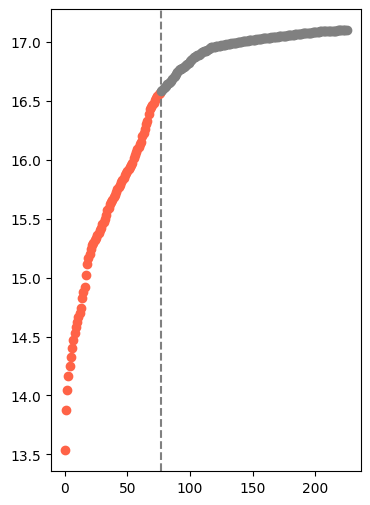

In [5]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

## Plot measured viral load data against uncalibrated model viral load

In [6]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Plot the diagnosed cases data

In [7]:
cases = pd.read_csv('data/datasetCumulCases.csv').dropna(how='any')
incident_cases = cases[['Time', 'cumulativecases']].rename(columns={'cumulativecases': 'reported incident cases', 'Time': 'Timestep'}).set_index('Timestep').diff().dropna()



In [8]:
measured_diagnosed_cases = pd.read_csv('data/cumulative_cases.csv')
measured_diagnosed_cases

,Timestep,D
0,0,370.0
1,1,668.0
2,2,978.0
3,3,1133.0
4,4,1332.0
...,...,...
108,111,136330.0
109,112,138392.0
110,113,140192.0
111,114,141854.0


## Plot measured diagnosed case data against uncalibrated model diagnosed cases

In [9]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="D_sol",
                            #markers={"Training": 77},
                            points=measured_diagnosed_cases.drop('Timestep',axis=1))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [10]:
data_train['D'] = measured_diagnosed_cases.drop('Timestep',axis=1)
data_train.reset_index().rename(columns={'time':'Timestep'}).to_csv('data/viral_load_and_diagnosed_cases.train.csv', index=False)

## Calibrate against diagnosed case data

In [11]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            template_model,
            'data/viral_load_and_diagnosed_cases.train.csv',
            100,
            timepoints=timepoints,
            verbose=True,
            num_iterations=1000,
            visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=1.0000029802322388, observation={'V': tensor(7.4826e+13), 'D': tensor(668.)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=2.000002861022949, observation={'V': tensor(1.1077e+14), 'D': tensor(978.)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=3.0000109672546387, observation={'V': tensor(1

iteration 0: loss = 24832.882526636124
iteration 25: loss = 12339.72383260727
iteration 50: loss = 9032.957093715668
iteration 75: loss = 7742.112986087799
iteration 100: loss = 7180.096889734268
iteration 125: loss = 6767.784021854401
iteration 150: loss = 6550.440027475357
iteration 175: loss = 6403.076909065247
iteration 200: loss = 6300.4098880290985
iteration 225: loss = 6180.961898326874
iteration 250: loss = 6131.165791988373
iteration 275: loss = 6055.087849617004
iteration 300: loss = 5914.789415597916
iteration 325: loss = 5913.8395302295685
iteration 350: loss = 5821.3304080963135
iteration 375: loss = 5838.756556034088
iteration 400: loss = 5830.213599443436
iteration 425: loss = 5772.050859212875
iteration 450: loss = 5717.663592815399
iteration 475: loss = 5730.456650495529
iteration 500: loss = 5711.268139839172
iteration 525: loss = 5708.650632143021
iteration 550: loss = 5662.425449132919
iteration 575: loss = 5667.163682460785
iteration 600: loss = 5651.5913944244385


In [12]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="D_sol",
                            markers={"Training": 77},
                            points=measured_diagnosed_cases.drop('Timestep',axis=1).rename(columns={'D': 'measured diagnosed cases'}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [13]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"measured viral load"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [14]:
sorted(set(calibrated_samples['data']['k_param'].values))

[0.49518370628356934,
 0.4951927065849304,
 0.4952106475830078,
 0.49522143602371216,
 0.4952694773674011,
 0.4953194856643677,
 0.49536821246147156,
 0.4953863024711609,
 0.49541187286376953,
 0.4954446852207184,
 0.4954608082771301,
 0.4954935908317566,
 0.49550318717956543,
 0.49552711844444275,
 0.49555885791778564,
 0.4956030249595642,
 0.4956050217151642,
 0.49561500549316406,
 0.4956349730491638,
 0.49564266204833984,
 0.4956599175930023,
 0.4956720471382141,
 0.4956861734390259,
 0.4956955909729004,
 0.4956966042518616,
 0.4956998825073242,
 0.4957062602043152,
 0.4957093894481659,
 0.49571144580841064,
 0.49571341276168823,
 0.49571457505226135,
 0.4957343339920044,
 0.49573683738708496,
 0.495750367641449,
 0.495764821767807,
 0.4957672655582428,
 0.49579235911369324,
 0.4958009123802185,
 0.49580100178718567,
 0.49580785632133484,
 0.4958118200302124,
 0.49581968784332275,
 0.4958198666572571,
 0.4958259165287018,
 0.49583327770233154,
 0.49583715200424194,
 0.49583807587623